In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [3]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 02:14:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [44]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from sklearn.manifold import TSNE
import seaborn as sns
from pyspark.sql.functions import desc  # This line is essential for sorting
import json
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

warnings.filterwarnings("ignore")
data_path='/kaggle/input/transactions-data-big-data/Transactions Data/Transactions Data'

# Read the data

In [6]:
from pyspark.sql import functions as F

# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the columns to double type
users_df = users_df.withColumn("per_capita_income", F.regexp_replace("per_capita_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("yearly_income", F.regexp_replace("yearly_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("total_debt", F.regexp_replace("total_debt", "[\$,]", "").cast("double"))

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [31]:
from pyspark.sql import functions as F

# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'amount' column to double type
transactions_df = transactions_df.withColumn("amount", F.regexp_replace("amount", "[\$,]", "").cast("double"))

# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|     id|               date|client_id|card_id|amount|         use_chip|merchant_id|  merchant_city| mcc|  errors|target|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33|Swipe Transaction|      33326|        Kahului|4121|No Error|    No|
|7475347|2010-01-01 00:36:00|      114|   3398| -64.0|Swipe Transaction|      61195|North Hollywood|5541|No Error|    No|
|7475378|2010-01-01 01:19:00|     1575|   2112| 17.14|Swipe Transaction|      29232|         Osprey|4121|No Error|    No|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
only showing top 3 rows



In [9]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'credit_limit' column to double type
cards_df = cards_df.withColumn("credit_limit", F.regexp_replace("credit_limit", "[\$,]", "").cast("double"))

# Check the count of rows
cards_df.count()

4514

# Analysis of Common Transaction Types 

In [32]:
with open("/kaggle/input/transactions-data-big-data/mcc_codes.json", "r") as f:
    mcc_dict = json.load(f)

# Convert to list of dicts
mcc_list = [{"mcc": int(k), "description": v} for k, v in mcc_dict.items()]

# Create Spark DataFrame
mcc_df = spark.createDataFrame(mcc_list)
mcc_df.printSchema()
transactions_df.printSchema()

transactions_df = transactions_df.join(mcc_df, on="mcc", how="left")

root
 |-- description: string (nullable = true)
 |-- mcc: long (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)
 |-- target: string (nullable = true)



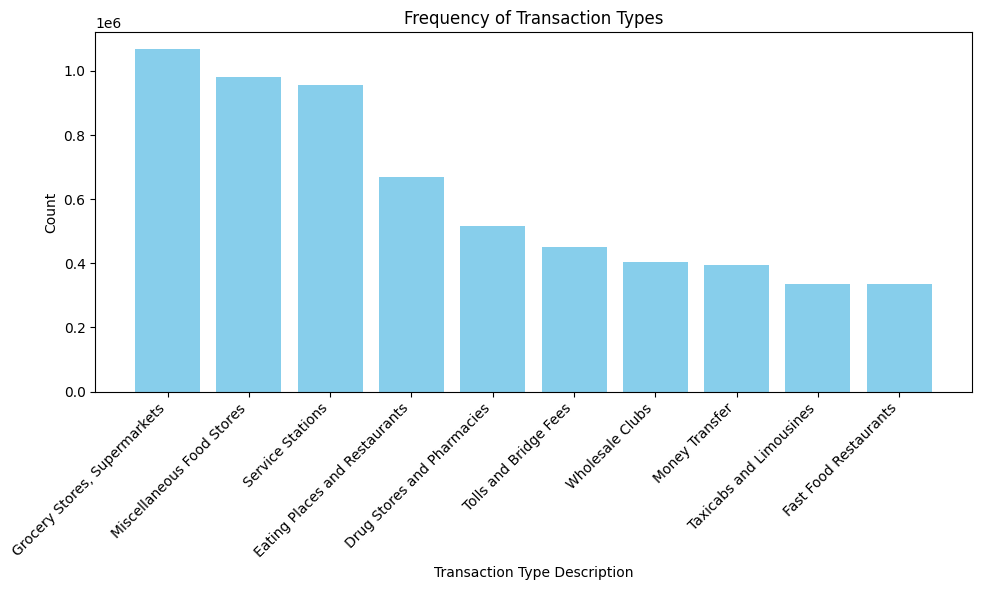

In [42]:

transaction_type_counts = transactions_df.groupBy("description").count()

#  Sort to find the most frequent transaction types
sorted_types = transaction_type_counts.orderBy(desc("count")).limit(10)
pandas_df = sorted_types.toPandas()

# Histogram (Bar Chart)
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['description'], pandas_df['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Transaction Type Description")
plt.ylabel("Count")
plt.title("Frequency of Transaction Types")
plt.tight_layout()
plt.show()


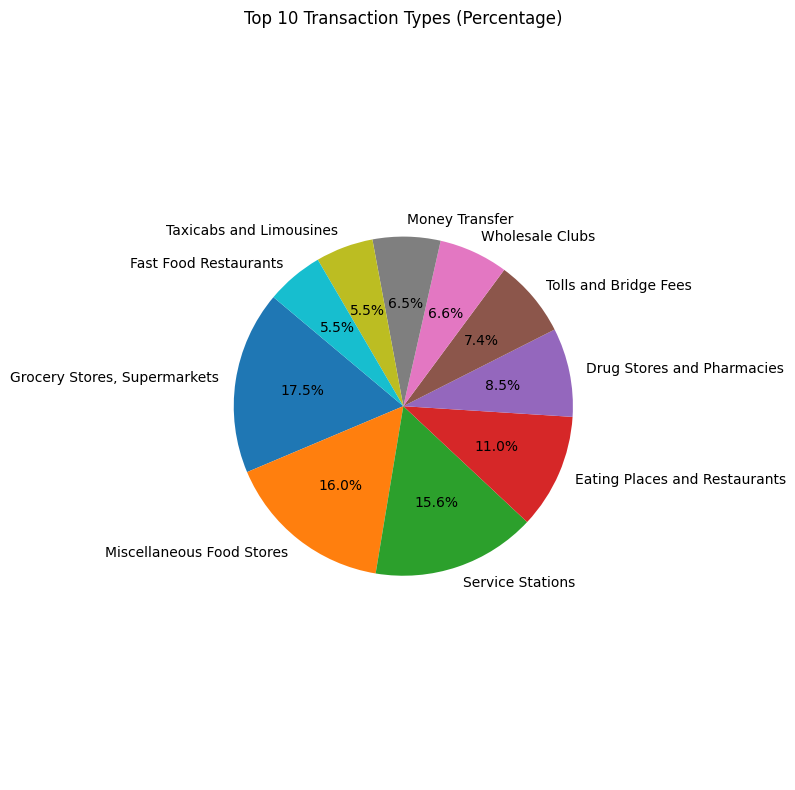

In [41]:
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(pandas_df['count'], labels=pandas_df['description'], autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Transaction Types (Percentage)")
plt.axis('equal')  # Equal aspect ratio ensures a circle.
plt.tight_layout()
plt.show()

In [54]:
sorted_types.printSchema()

root
 |-- description: string (nullable = true)
 |-- count: long (nullable = false)



In [57]:
##find which transcation types are more likely to be fraudulent.

# Get total count and fraud count per transaction type
transaction_fraud_stats = transactions_df.filter("target == 'Yes'") \
    .groupBy("description") \
    .agg(
        F.count("*").alias("fraud_count")
    )


In [60]:

# transaction_fraud_stats.show()
# Calculate fraud rate without join
transaction_with_fraud_rate = sorted_types.join(transaction_fraud_stats, on="description", how="left") \
    .withColumn("fraud_rate", F.col("fraud_count") / F.col("count")*100).orderBy(desc("fraud_rate"))

# Show sorted results by fraud rate
print("fraud rate in top 10 transcation types")
transaction_with_fraud_rate.orderBy(F.desc("fraud_rate")).show()

fraud rate in top 10 transcation types


+--------------------+-------+-----------+--------------------+
|         description|  count|fraud_count|          fraud_rate|
+--------------------+-------+-----------+--------------------+
|     Wholesale Clubs| 403343|        991| 0.24569659074286648|
|      Money Transfer| 394401|        725| 0.18382306332894693|
|Drug Stores and P...| 517400|        479| 0.09257827599536142|
|Taxicabs and Limo...| 335586|        300| 0.08939586275947149|
|Fast Food Restaur...| 334333|        235|  0.0702892026811592|
|Grocery Stores, S...|1066833|        425| 0.03983753783394402|
|Eating Places and...| 669808|        121|0.018064878293481117|
|    Service Stations| 955123|        168|  0.0175893576010629|
|Miscellaneous Foo...| 979396|        131|0.013375590670168145|
|Tolls and Bridge ...| 451814|       NULL|                NULL|
+--------------------+-------+-----------+--------------------+



In [61]:
transaction_with_fraud_rate = transaction_type_counts.join(transaction_fraud_stats, on="description", how="left") \
    .withColumn("fraud_rate", F.col("fraud_count") / F.col("count")*100).orderBy(desc("fraud_rate")).limit(10)

print("Most common types with fraud transcations")
transaction_with_fraud_rate.orderBy(F.desc("fraud_rate")).show()



top 10 transcation types with fraud rates


+--------------------+-----+-----------+------------------+
|         description|count|fraud_count|        fraud_rate|
+--------------------+-----+-----------+------------------+
|        Cruise Lines|  276|        165| 59.78260869565217|
|Music Stores - Mu...|  204|         76|37.254901960784316|
|Miscellaneous Fab...|  245|         29| 11.83673469387755|
|Computers, Comput...| 1883|        204|10.833775889537971|
|Floor Covering St...|  222|         23| 10.36036036036036|
|Miscellaneous Met...|  256|         22|           8.59375|
|  Electronics Stores| 4689|        402| 8.573256557901471|
|Fabricated Struct...|  273|         22| 8.058608058608058|
|Precious Stones a...| 3525|        242| 6.865248226950355|
|Furniture, Home F...| 2600|        170| 6.538461538461539|
+--------------------+-----+-----------+------------------+

